In [ ]:
!pip install osmnx folium matplotlib mapclassify scikit-learn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely import wkt
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
import scipy

## Download list of building and amenity types from Open Street Map (OSM)

In [ ]:
tab_buildings = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:building', match='Value')
tab_amenities = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:amenity', match='Value')

In [ ]:
building_types = tab_buildings[0]
amenity_types = tab_amenities[0]

# Format building types and amenity types to have only one column label per column
building_types.columns = building_types.columns.droplevel(1)
amenity_types.columns = amenity_types.columns.droplevel(1)

## Remove undesired amenity types

In [ ]:
bad_amenities = ['driving_school', 'car_rental', 'car_wash', \
    'vehicle_inspection', 'fuel', 'grit_bin', \
    'motorcycle_parking', 'parking', 'parking_entrance', \
    'parking_space', 'taxi']

In [ ]:
amenity_types = amenity_types[(amenity_types['Key'] == 'amenity') & (~amenity_types['Value'].isin(bad_amenities))]
desired_amenities = list(amenity_types['Value'])
desired_slices = [np.arange(18,25), np.arange(26, 37), np.arange(38, 53), np.arange(69, 72)]
desired_inds = np.concatenate(desired_slices)
desired_types = list(building_types.loc[desired_inds]['Value'])

Modified Silhouette -- Get silhouette scores + cluster densities for each point, where cluster density = cardinality/voronoi cell area

In [ ]:
from sklearn.metrics import silhouette_samples
from scipy.spatial import ConvexHull

def modified_silhouette(cluster_df, cluster_col='Label', lng_dim='Longitude', lat_dim='Latitude'):
  labels = cluster_df[cluster_col].unique()
  scores = []
  if len(labels) < 2:
    return 0.0

  print("Start silhouettes")
  print(cluster_df.columns)
  silhouettes = silhouette_samples(cluster_df[[lng_dim, lat_dim]], cluster_df[cluster_col])
  print("Got Scores")
  cluster_df["Score"] = silhouettes

  for label in labels:
    label_df = cluster_df[cluster_df[cluster_col] == label]
    cardinality = label_df.shape[0]
    voronoi_cell = ConvexHull(label_df[[lng_dim, lat_dim]])
    density = cardinality/voronoi_cell.area
    cluster_silhouette = np.mean(label_df["Score"]) + density
    scores.append(cluster_silhouette)

  return np.sum(scores)

In [ ]:
def entropy(cluster_df, cluster_col='Label', lng_dim='Longitude', lat_dim='Latitude', amen_dim='Amenity'):
  labels = cluster_df[cluster_col].unique()
  sum_of_scores = 0.0
  scores = []

  for label in labels:
    label_df = cluster_df[cluster_df[cluster_col] == label]
    vc = list(label_df[amen_dim].value_counts(normalize=True))
    print(sum(vc))
    entropy = 0.0
    for val in vc:
      entropy -= val * np.log2(val)
    #scaled_card = label_df.shape[0]/cluster_df.shape[0]
    scores.append(entropy)

  print(scores)
  return np.var(scores)

In [ ]:
from pprint import pprint
import math

class ClusteringResult:
  def __init__(self, df, score, n_clusters, centers=None, estimator=None):
    self.df = df
    self.score = score
    self.n_clusters = n_clusters
    self.centers = centers
    self.estimator = estimator

def density_score(cluster_df, cluster_col='Label', lng_dim='Longitude', lat_dim='Latitude'):
  labels = cluster_df[cluster_col].unique()
  sum_of_scores = 0.0
  scores = []

  for label in labels:
    label_df = cluster_df[cluster_df[cluster_col] == label]
    cardinality = label_df.shape[0]

    centroid_lng, centroid_lat = sum(label_df[lng_dim])/cardinality, sum(label_df[lat_dim])/cardinality

    distances = [0.0] * cardinality
    for idx, lng in enumerate(list(label_df[lng_dim])):
      distances[idx] += (lng - centroid_lng) ** 2
    for idx, lat in enumerate(list(label_df[lat_dim])):
      distances[idx] += (lat - centroid_lat) ** 2

    scores.append(cardinality/np.var(distances))
    sum_of_scores += cardinality/np.var(distances)

  return np.var(scores)

def cluster_facilities(center_lat, center_lng, dist, max_k, desired_types, desired_amenities, score_func, clustering, use_type=False, min_k=1):
  center_point = (center_lat, center_lng)
  tags = {'building': desired_types, 'amenity': desired_amenities}
  G = ox.geometries_from_point(center_point, tags, dist=dist)

  #assemble dataset of points
  X = []
  for p in list(G.geometry.node):
    X.append([p.x, p.y])
  X = np.array(X)
  X_df = pd.DataFrame(X, columns=['Longitude', 'Latitude'])
  if use_type:
    X_df['Amenity'] = list(G.amenity.node)
  num_datapoints = X_df.shape[0]
  print(f'Training Data Points: {num_datapoints}')

  result = []

  if max_k > 0:
    for k in range(min_k, max_k + 1):
      #km = KMeans(n_clusters=k)
      #km.fit(X_df)
      #labels = km.labels_

      cl = clustering(n_clusters=k)
      print(f"FITTING {k}")
      cl.fit(X_df[['Longitude', 'Latitude']])
      print("FITTING DONE")
      labels = cl.labels_

      X_df['Label'] = labels

      print("SCORING")
      score = score_func(X_df)
      print("SCORING DONE")

      result.append(ClusteringResult(X_df.copy(), score, k, estimator=cl, centers=cl.cluster_centers_))
      print(f"FINISHED {k} CLUSTERS, score {score}")

      result.sort(key=lambda x : x.score)
  else:
    cl = clustering()
    print("FITTING")
    res = cl.fit(X_df[['Longitude', 'Latitude']])
    print("FITTING DONE")
    labels = cl.labels_

    X_df['Label'] = labels
    score = score_func(X_df)
    result.append(ClusteringResult(X_df.copy(), score, len(labels), centers=res.cluster_centers_))

  return result

In [ ]:
#BOSTON: 42.319821, -71.079803
#LA: 34.0549, -118.2426
result = cluster_facilities(42.319821, -71.079803, 20000, 50, desired_types, desired_amenities, entropy, KMeans, True, min_k=1)

<ipython-input-9-05cca5541124>:37: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  G = ox.geometries_from_point(center_point, tags, dist=dist)


Training Data Points: 16110
FITTING 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
[3.934753589655436]
SCORING DONE
FINISHED 1 CLUSTERS, score 0.0
FITTING 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0
1.0000000000000002
[4.068217909469494, 3.797214545293956]
SCORING DONE
FINISHED 2 CLUSTERS, score 0.018360705848614826
FITTING 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999996
0.9999999999999993
[4.062786735185718, 3.7889980043325693, 4.095468826653437]
SCORING DONE
FINISHED 3 CLUSTERS, score 0.018883639242101197
FITTING 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999999
0.9999999999999997
1.0
1.0000000000000004
[3.967931495060704, 4.069809560577712, 3.211646420722126, 4.063437654904267]
SCORING DONE
FINISHED 4 CLUSTERS, score 0.128343785180444
FITTING 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000007
[3.8852657031861217, 4.2806974823129735, 3.3472983438437622, 4.007710783716484, 3.9707108632498422]
SCORING DONE
FINISHED 5 CLUSTERS, score 0.09344291969179612
FITTING 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999999
0.9999999999999996
1.0000000000000002
0.9999999999999998
1.0
[3.9834867796258715, 3.724626645203408, 4.254319420069056, 3.3059466628222087, 4.074390657993685, 3.8470702592329924]
SCORING DONE
FINISHED 6 CLUSTERS, score 0.09033665989174304
FITTING 7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000007
0.9999999999999999
0.9999999999999993
0.9999999999999999
[3.973627655267727, 3.746457956082024, 4.251093128163298, 3.0452028047251614, 4.072930276306583, 3.2983731234941733, 4.100688245949987]
SCORING DONE
FINISHED 7 CLUSTERS, score 0.17442441882938256
FITTING 8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999998
0.9999999999999996
1.0000000000000007
0.9999999999999996
1.0000000000000002
0.9999999999999994
1.0000000000000004
[3.937143198280562, 3.7533640052310675, 4.256864548421099, 2.9954690239065322, 4.077233240885994, 3.3907378150824594, 4.298780692974648, 3.6186346258195017]
SCORING DONE
FINISHED 8 CLUSTERS, score 0.17529549333666555
FITTING 9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999994
1.0000000000000004
1.0000000000000007
0.9999999999999997
0.9999999999999996
0.9999999999999996
1.0000000000000016
1.0000000000000004
0.9999999999999996
[3.8975653645716037, 3.9184113104065434, 3.4236451994832064, 4.243429729446706, 3.1201153625991984, 4.076644263372931, 3.438623351656187, 4.298457670473362, 3.6708217425637786]
SCORING DONE
FINISHED 9 CLUSTERS, score 0.14388083516094655
FITTING 10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999994
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999994
[3.892428361670266, 3.980100939136052, 3.2514587324854123, 3.997999611449722, 3.150962268538784, 4.282638700262982, 3.4304453267410255, 4.29507341858072, 3.6708217425637786, 3.7132287488334055]
SCORING DONE
FINISHED 10 CLUSTERS, score 0.14299435024832674
FITTING 11


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000016
0.9999999999999993
1.0000000000000002
0.9999999999999997
0.9999999999999994
1.0000000000000002
0.9999999999999994
0.9999999999999993
[3.9256997097877293, 2.876283563032133, 3.9111998550889098, 4.049584851981594, 3.0667845010470005, 4.260100384445736, 3.3283400623523103, 4.307562337948536, 3.6280979785392993, 3.7132287488334055, 3.9716709514722703]
SCORING DONE
FINISHED 11 CLUSTERS, score 0.1988119697271037
FITTING 12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999999
1.0000000000000004
1.0
1.0000000000000009
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999996
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999996
[4.1386428729397515, 3.769383810296087, 2.8756051448793567, 3.8677796941956024, 3.052641926077708, 4.278279477440755, 4.025708480864684, 3.348862387052013, 4.317141114831133, 3.3055849494140523, 3.686473322903203, 4.0346506362771155]
SCORING DONE
FINISHED 12 CLUSTERS, score 0.21074371021392305
FITTING 13


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999988
0.9999999999999998
0.9999999999999997
0.9999999999999993
0.9999999999999997
0.9999999999999996
1.0000000000000002
0.9999999999999992
1.0000000000000002
1.0
0.9999999999999996
1.0000000000000004
0.9999999999999996
[4.126363832016588, 3.7785678837982246, 2.8866082921880736, 3.9108542271954674, 3.052641926077708, 4.285384567137038, 3.692206011736881, 3.351514932021758, 4.3092216443169855, 3.6497385702232865, 3.323794526373513, 3.6942739770147077, 4.0346506362771155]
SCORING DONE
FINISHED 13 CLUSTERS, score 0.18496192578418155
FITTING 14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999998
1.0000000000000002
1.0000000000000004
0.9999999999999997
0.9999999999999997
0.9999999999999994
1.0000000000000002
0.9999999999999999
1.0000000000000007
0.9999999999999997
1.0000000000000004
0.9999999999999996
0.9999999999999998
0.9999999999999994
[4.134758627809955, 3.7529384301090514, 2.9031649508676787, 3.915663588840878, 3.0701333309836087, 4.289285726575422, 3.68956733957276, 2.8626051709277776, 4.251903206820378, 3.639758089701988, 3.6942739770147077, 3.3435236319745854, 3.94823706360264, 3.982214751923629]
SCORING DONE
FINISHED 14 CLUSTERS, score 0.20627139741405906
FITTING 15


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
0.9999999999999992
1.0000000000000002
1.0000000000000004
0.9999999999999993
0.9999999999999996
1.0000000000000004
0.9999999999999999
0.9999999999999992
1.0000000000000004
0.9999999999999996
0.9999999999999996
1.0000000000000004
1.0
1.0000000000000002
[4.090450345675247, 3.7381628382140883, 3.798039069002794, 3.8953940217902936, 3.0667845010470005, 4.29083068650696, 2.781922971138901, 3.6933882407698695, 4.0426414778771775, 2.8656886722935084, 3.646505892469859, 3.673470557740024, 3.3423666317430647, 4.091429668147745, 3.9466196456241156]
SCORING DONE
FINISHED 15 CLUSTERS, score 0.19563063220412555
FITTING 16


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999997
0.9999999999999994
0.9999999999999997
0.9999999999999992
1.0000000000000002
0.9999999999999996
1.0
[3.712913524754608, 4.0919017356907625, 3.7961182280381025, 2.8669140926482197, 3.9095094292242987, 3.052641926077708, 4.286387563491833, 4.011400625588978, 3.6439599932974285, 2.8983518269526005, 3.615752315719306, 3.6928296026446574, 3.3812948014961264, 3.865489696664519, 4.294473859220431, 3.9524729797337326]
SCORING DONE
FINISHED 16 CLUSTERS, score 0.1849265961652599
FITTING 17


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999999
1.0000000000000007
1.0000000000000002
1.0000000000000007
0.9999999999999997
0.9999999999999998
0.9999999999999993
0.9999999999999997
1.0000000000000004
0.9999999999999992
0.9999999999999997
1.0000000000000002
0.9999999999999996
1.0000000000000007
1.0
1.0000000000000002
[3.6945321031786444, 4.086992167641811, 3.8006015258189487, 2.8644324543147763, 3.9158404573192023, 3.052641926077708, 4.292146382255097, 4.010981276809045, 3.649124732832437, 2.902420183440332, 3.57177979338784, 3.5913495135379416, 3.396914995101227, 3.375331796400792, 3.867669959590406, 4.277493118970388, 3.958459521709313]
SCORING DONE
FINISHED 17 CLUSTERS, score 0.17901040774241025
FITTING 18


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
1.0000000000000002
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000007
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999994
0.9999999999999992
0.9999999999999998
0.9999999999999994
1.0000000000000009
1.0000000000000004
0.9999999999999993
[3.7024281042431273, 4.080946216464493, 3.8309154354025736, 3.5044292030702002, 3.876435952266649, 3.045920051816176, 4.293620381472002, 2.5814053596968223, 4.011400625588978, 3.6736976345431946, 2.879317608223583, 3.669061527243435, 3.581281865454133, 3.339146738150424, 3.3008432215461734, 3.914736080562331, 4.2984728949147835, 3.9506959187489348]
SCORING DONE
FINISHED 18 CLUSTERS, score 0.2079424732528288
FITTING 19


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999991
0.9999999999999999
1.0
1.0000000000000004
0.9999999999999991
0.9999999999999996
0.9999999999999999
1.0000000000000007
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999992
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.000000000000001
1.0000000000000004
1.0000000000000007
1.0000000000000002
[3.6678288277211344, 4.084820405347658, 3.897065213327046, 3.8432264048724867, 3.955114401711412, 3.0481755163354194, 4.293620381472002, 3.243156900396465, 4.011400625588978, 3.637080148095185, 2.8729295639655708, 3.57177979338784, 1.2570155967904013, 3.5913495135379416, 3.396914995101227, 3.297299751367306, 3.7854726732804718, 4.274865354125188, 3.9546840817079274]
SCORING DONE
FINISHED 19 CLUSTERS, score 0.4388075391248235
FITTING 20


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999992
0.9999999999999991
1.0000000000000007
1.0000000000000009
1.0000000000000002
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0
1.0
1.0000000000000002
0.9999999999999994
0.9999999999999994
1.0000000000000013
0.9999999999999992
0.9999999999999997
1.0000000000000002
0.9999999999999988
[3.6635123122945172, 4.105812026208565, 3.8495136645084735, 3.838454777526671, 3.9194601695290867, 3.9018592011960376, 3.0481755163354194, 3.24909069852184, 3.9501666240807416, 3.9527782945852663, 4.166140950961491, 3.4841152366392514, 2.8610520886357342, 1.2991875874244947, 3.659169296274125, 3.3101031142394524, 3.927218773689308, 4.315977329951838, 3.9656228219235086, 3.5349839929503677]
SCORING DONE
FINISHED 20 CLUSTERS, score 0.4132879139294534
FITTING 21


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
0.9999999999999998
0.9999999999999997
0.9999999999999997
0.9999999999999992
0.9999999999999998
1.0
0.9999999999999994
1.0000000000000004
0.9999999999999996
0.9999999999999994
1.0
0.9999999999999993
1.0000000000000002
0.9999999999999994
1.0000000000000002
1.000000000000001
0.9999999999999996
0.9999999999999992
0.9999999999999998
0.9999999999999994
[3.6789758316064587, 4.118229306760079, 3.7925442513055003, 3.169094329774277, 3.933709078959583, 3.0291035310282006, 4.27936402035699, 2.582131135322631, 4.008262331099253, 4.000698048916495, 3.184350093438701, 3.2799711357288355, 2.9183625882082063, 3.518561586967328, 3.3749007534489435, 3.927697543020303, 3.6834206670466725, 4.27806576526333, 3.198754096875675, 3.8984048266986617, 3.541049239617078]
SCORING DONE
FINISHED 21 CLUSTERS, score 0.20868709002022334
FITTING 22


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999999
0.9999999999999997
1.0000000000000004
1.0000000000000007
0.9999999999999998
0.9999999999999993
0.9999999999999997
1.0000000000000004
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.9999999999999999
1.000000000000001
0.9999999999999996
1.0000000000000007
[4.220663721269956, 4.115063044402374, 3.8055817776711796, 3.8376843007100363, 3.7877161192298465, 2.626254969727083, 4.280854822794053, 3.4375481564723835, 3.647172420869756, 3.9894281860853593, 4.000698048916495, 3.1942553800161813, 3.188302800979454, 4.063255319108136, 2.6995207557444103, 3.004347189174336, 3.518561586967328, 3.3749007534489435, 3.9308672341918856, 3.6834206670466725, 3.232738113188195, 4.006865211446279]
SCORING DONE
FINISHED 22 CLUSTERS, score 0.214390873012482
FITTING 23


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0000000000000004
0.9999999999999998
1.0000000000000002
0.9999999999999996
0.9999999999999993
0.9999999999999998
1.0000000000000007
0.9999999999999999
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000007
0.9999999999999996
0.9999999999999996
1.0000000000000002
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999988
[3.702560013120521, 4.089913238603891, 3.818377185155768, 2.9710479781458594, 3.9757400157857536, 3.8025555916469265, 3.0143618898495466, 4.280854822794053, 3.103231708668975, 3.9607802094369804, 3.9197395810107065, 3.2411971018499135, 2.9301347961391637, 1.791082453984906, 3.518561586967328, 3.52497784954664, 3.2973120503108313, 3.5787359971414663, 3.782934560629931, 4.312737296186251, 3.4249992634372313, 3.948431323280759, 3.5349839929503677]
SCORING DONE
FINISHED 23 CLUSTERS, score 0.2931635144325213
FITTING 24


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
0.9999999999999992
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999996
1.0000000000000007
1.0000000000000002
0.9999999999999998
1.0
1.0
1.0000000000000004
0.9999999999999994
0.9999999999999999
0.9999999999999996
0.9999999999999996
1.000000000000001
0.9999999999999998
0.9999999999999998
0.9999999999999994
0.9999999999999996
0.9999999999999988
[3.6822079000831422, 4.086089883760364, 3.757787037438499, 3.8223733040579466, 3.0161401162496024, 4.320432525183213, 3.3723246904698367, 3.9617910061617985, 3.282358017551933, 3.2782766440895568, 2.929669647457996, 3.9596714763656187, 1.2249803243373878, 3.504864711109678, 3.3749007534489435, 3.9119119296545355, 3.85495418749328, 3.8468164444439905, 3.6834206670466725, 3.63054317865096, 4.3099054451870895, 3.333582675650044, 3.938056056525118, 3.5349839929503677]
SCORING DONE
FINISHED 24 CLUSTERS, score 0.364277347055797
FITTING 25


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0000000000000002
0.9999999999999997
0.9999999999999997
0.9999999999999991
1.0000000000000002
0.9999999999999998
0.9999999999999991
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999997
1.0000000000000004
1.0000000000000004
0.9999999999999993
0.9999999999999994
0.9999999999999997
0.9999999999999996
1.0000000000000002
1.0000000000000002
0.999999999999999
1.0000000000000009
1.0
0.9999999999999988
[3.6925206180035652, 4.085838085781238, 3.792174006891376, 1.6809188110765059, 3.9385897147812714, 3.8360428135396254, 2.626254969727083, 4.207566794851654, 2.377590194981387, 3.8744673340903146, 4.063297974834905, 3.3995524766911265, 3.1254525473298576, 4.101451661699031, 2.936929700604151, 3.500487518603256, 3.376900861437923, 3.9180598068220105, 3.238143738848388, 3.7047905485496258, 4.2494671981512955, 3.317157551992311, 3.2289275000032034, 3.940270380778455, 3.5349839929503677]
SCORING DONE
FINISHED 25 CLUSTERS, score 0.3620

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999996
1.0
1.0
0.9999999999999998
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999996
1.0000000000000009
0.9999999999999997
1.0
1.0000000000000007
1.0
1.0000000000000007
1.0000000000000002
0.9999999999999994
1.0000000000000002
0.9999999999999994
1.0000000000000002
0.9999999999999996
0.9999999999999999
0.9999999999999988
[3.805292957844879, 3.8313175808754143, 3.7797222140449693, 1.7577619599799463, 3.9180720071990085, 3.833413501235142, 4.140434511450524, 3.026793472286389, 4.187251261668143, 2.4420792563831255, 3.3254261210027214, 4.094338823994879, 3.2860132212103395, 3.9487647570569644, 2.924244596735872, 3.500581785196514, 3.3507375391177923, 3.954894102213347, 3.6242648373006294, 3.473688990819372, 4.310423181519074, 3.3089418603680376, 3.232301636395316, 3.929174666656833, 3.1276659612681734, 3.5349839929503677]
SCORING DONE
FINISHED 26 CLUSTERS, score 0.31187323176380605
FITTIN

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
0.9999999999999999
0.9999999999999996
1.0
0.9999999999999997
1.0000000000000002
0.9999999999999998
0.9999999999999999
1.0000000000000002
0.9999999999999998
1.0000000000000002
0.9999999999999996
1.0000000000000002
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999993
0.9999999999999994
0.9999999999999999
0.9999999999999994
0.9999999999999997
0.9999999999999996
1.0000000000000009
0.9999999999999997
1.0000000000000002
0.9999999999999988
[3.81404097622774, 3.8457768801015484, 3.9284675022215207, 1.7577619599799463, 3.671314309763438, 3.808781375751251, 4.2646235261725955, 2.642968172791705, 4.141624905157687, 2.377590194981387, 3.393002933578964, 4.02569690065613, 4.069248934053795, 3.3885404493915225, 3.1254525473298576, 4.06876869990786, 2.9242971329027485, 3.520616716262901, 3.376900861437923, 3.9982497608314223, 3.688560561307647, 3.6207153323716894, 3.3280190717531535, 3.2289275000032034, 3.92280788256191

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0000000000000004
0.9999999999999997
0.9999999999999997
1.0000000000000004
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999998
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999997
0.9999999999999994
1.0000000000000002
0.9999999999999994
1.0000000000000004
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000009
0.9999999999999999
0.9999999999999993
0.9999999999999996
[4.224413310846449, 3.9073567817985806, 3.8208209907814736, 1.7041535087946171, 3.9282295664035853, 3.83331367448372, 4.235473957999054, 2.574588307743211, 4.162680765859337, 2.377590194981387, 3.3305652695208074, 3.77142193013125, 4.062931517247142, 3.2883839389575096, 3.2340796053723797, 4.024266860256223, 4.019648076115181, 2.8750004525933015, 3.502218169654029, 3.376900861437923, 3.961231403627627, 3.688560561307647, 3.4585821878142675, 3.3140929224797357, 3.2289275000

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
1.0000000000000004
0.9999999999999996
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999996
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999999
0.9999999999999997
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999996
0.9999999999999997
1.0000000000000004
0.9999999999999997
1.0000000000000007
1.0
0.9999999999999999
0.9999999999999996
[3.614656625514535, 4.049854742965165, 3.760796678433585, 1.7577619599799463, 3.9423832112405166, 3.8318738143883984, 3.977616713033943, 2.642968172791705, 3.294179354441458, 2.3694091429429465, 3.3805770015466403, 3.7034976931940267, 4.009704313857998, 4.16204481578223, 3.3885404493915225, 3.1254525473298576, 4.029387611636032, 4.010527192174872, 2.9242971329027485, 3.5392998880453685, 3.515174683844979, 3.924110506815711, 3.555816032697457, 3.511568616

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999994
1.0
0.9999999999999997
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999999
0.9999999999999997
1.0
1.0000000000000004
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999992
0.9999999999999994
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999996
1.0000000000000004
1.0000000000000004
0.9999999999999996
[3.630846523481877, 4.058173168367781, 3.8087064357324745, 2.66182658995374, 3.6562271567142997, 3.7454219460004636, 2.638770509402189, 3.4229756489841714, 3.1580166796387275, 3.8391722810932336, 4.088841056514326, 4.209366521598114, 3.113192882300916, 3.353484027298281, 3.1254525473298576, 3.9979935896566356, 3.96888134450574, 3.554475748664778, 1.768272872399342, 2.936929700604151, 3.425468352836985, 3.912797923267544, 3.756180866772484, 3.62006199

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.000000000000001
1.0000000000000004
0.9999999999999994
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0
0.9999999999999997
1.0
1.0000000000000002
0.9999999999999996
1.0000000000000013
0.9999999999999996
1.0000000000000002
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999998
0.9999999999999997
0.9999999999999997
1.0
0.9999999999999996
0.9999999999999994
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999999
0.9999999999999999
0.9999999999999996
[3.5465943900554295, 4.0451969997270645, 3.9262565095410986, 1.5626104670338177, 3.7524211115298094, 3.9147967245647686, 2.638770509402189, 3.4198689036116092, 3.1174134359909655, 4.287341315196504, 4.072971824276585, 3.971196148613736, 4.029309797405958, 3.3518460007708164, 3.1254525473298576, 4.029387611636032, 3.9722559569736293, 1.8988840211099902, 2.9191633063162556, 3.558576841109299, 3.3500707656601976, 3.2065580987284044, 3.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999999
0.9999999999999997
1.0000000000000004
1.0000000000000004
0.9999999999999999
0.9999999999999997
1.0
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999994
1.0000000000000002
0.9999999999999996
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999992
0.9999999999999999
0.9999999999999994
0.9999999999999996
[3.678680185365237, 3.7592154769771255, 3.7980890006852386, 1.6752429078729343, 3.6975684287494603, 3.9685652295982523, 4.226350129394365, 2.626254969727083, 4.0050683477107105, 3.1140684937930754, 3.3254261210027214, 3.6920708347497104, 4.071262910475917, 3.9373560655683963, 3.3589844103606707, 3.1254525473298576, 4.000047219634709, 3.9708330125413567, 1.795580655658677, 2.9242971329027485, 3.4790438792887186, 3.3779675781169654, 3.956655592

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999991
0.9999999999999993
0.9999999999999993
0.9999999999999996
1.0000000000000002
1.000000000000001
0.9999999999999999
0.9999999999999997
0.9999999999999989
0.9999999999999998
0.9999999999999999
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0000000000000002
0.9999999999999998
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999996
1.0000000000000004
0.9999999999999991
0.9999999999999997
0.9999999999999997
1.0
0.9999999999999994
1.0000000000000002
0.9999999999999996
0.9999999999999999
1.0000000000000002
0.9999999999999996
[3.8564788878165253, 4.011969883513211, 3.3338666844746285, 1.6909882632212272, 3.8325190802955937, 3.941569588334168, 4.115338214899483, 2.574588307743211, 4.149439760373781, 3.052811888313068, 3.326856898046213, 3.654736129425569, 4.090300667546659, 3.3830422879276068, 3.1250495709896846, 4.029387611636032, 4.010527192174872, 1.795580655658677, 2.9253794139533227,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999999
0.9999999999999999
1.0000000000000002
0.9999999999999996
1.0000000000000004
0.9999999999999997
0.9999999999999999
0.9999999999999994
1.0000000000000004
1.0000000000000004
0.9999999999999994
1.0
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999999
1.0000000000000002
0.9999999999999993
0.9999999999999994
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999996
[3.6114866900019607, 4.0232010545454795, 3.7876117715542126, 1.2974545032224754, 3.571044180430889, 3.95594063235951, 2.5698450900415137, 3.4600988665262813, 3.1096715396301415, 3.376830015219586, 3.7761667847933693, 4.124703796553015, 4.220110430227362, 2.939228376173753, 3.170590304713559, 2.8171141048624007, 3.9979935896566356, 3.9884645334290756, 1.8809309248165504, 2.792

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999993
1.0
1.0
1.0000000000000004
1.0000000000000004
0.9999999999999991
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999994
1.0000000000000002
0.999999999999999
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999998
0.9999999999999998
0.9999999999999994
0.9999999999999997
1.0000000000000002
0.9999999999999994
0.9999999999999999
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0
1.000000000000001
0.9999999999999999
0.9999999999999998
0.999999999999999
0.9999999999999996
[3.768501849570522, 4.018715457329563, 3.6116598505096373, 2.6299412675414224, 3.7303037946086754, 3.7371064136790144, 3.7140457066204604, 4.068624191258663, 2.626254969727083, 3.157312787873768, 3.167849155763669, 3.4068448104178577, 3.654736129425569, 4.136711219151034, 3.980862307171832, 4.135954770943499, 2.8133902794703185, 3.3589844103606707, 3.2451901845158178, 4.0293

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999996
1.0
1.0000000000000002
0.9999999999999993
1.0000000000000004
0.9999999999999996
0.9999999999999999
0.9999999999999996
0.9999999999999998
0.9999999999999998
0.9999999999999994
1.0
1.0000000000000004
1.0
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0000000000000004
0.9999999999999992
1.0000000000000002
0.9999999999999998
1.0
0.9999999999999997
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999999
0.9999999999999992
0.9999999999999999
0.9999999999999997
0.9999999999999996
[3.6471160718690316, 3.983496188669659, 3.7978328800949313, 1.6549829395779772, 3.162996964914264, 3.9338606875221824, 4.0393879102413495, 2.5698450900415137, 3.310031217964724, 2.3793198769074357, 3.313574388303885, 3.7596180189286565, 4.103042237376374, 3.9258303065669713, 4.0589768047003965, 3.1727066498077683, 2.818783488355992, 4.016388287722071, 3.93527036126293

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999993
0.9999999999999997
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999996
0.999999999999999
1.0
0.9999999999999997
0.9999999999999996
1.0
1.0
0.9999999999999997
0.9999999999999993
1.0
1.0
1.0000000000000007
0.9999999999999997
1.0000000000000007
1.0000000000000004
0.9999999999999996
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0000000000000002
0.9999999999999993
1.0000000000000007
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000016
1.0000000000000002
0.9999999999999999
1.0000000000000007
[3.617261853706043, 4.022168476048301, 3.477691537069015, 1.2974545032224754, 3.8369617701707686, 3.952146061938771, 3.5017792010855056, 4.034949274819866, 2.612228007162847, 3.310031217964724, 2.3706022112442207, 3.4211264607478875, 3.7347485159839797, 4.092186658302174, 3.723601283388179, 4.0589768047003965, 2.8255023435817552, 3.3639926850419286, 3.144979757193073, 4.032128582

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999999
1.0000000000000004
1.0
1.0
0.9999999999999996
1.0
0.9999999999999996
0.9999999999999999
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999998
1.0000000000000004
0.9999999999999997
1.0
0.9999999999999999
0.9999999999999998
1.0000000000000009
1.0000000000000004
0.9999999999999999
0.9999999999999994
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999996
1.0000000000000007
[3.6131279971499617, 3.9795893185656377, 3.6576907211448484, 1.7412394612280735, 3.707830026910681, 3.8574614282892856, 4.0393879102413495, 2.642968172791705, 3.3803621569451674, 3.139889214437193, 3.348911686539647, 3.6279416750725444, 4.107502363938225, 3.9253669580314305, 4.050014541688875, 3.316761666046854, 3.079118128681069, 4.029387611636032, 3.97915094

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
1.0000000000000007
0.9999999999999997
1.0
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999997
0.9999999999999997
0.9999999999999998
1.0000000000000002
0.9999999999999997
0.9999999999999994
0.9999999999999996
0.9999999999999998
1.0
1.0000000000000002
1.0000000000000004
0.9999999999999997
1.0000000000000004
0.999999999999999
1.0000000000000004
0.9999999999999996
0.9999999999999996
0.9999999999999999
0.9999999999999996
1.0000000000000004
0.9999999999999996
0.9999999999999997
1.0
0.9999999999999993
1.0000000000000002
0.9999999999999994
1.0000000000000004
[3.6471160718690316, 4.012812898386084, 3.711546310444829, 1.2816791957739546, 3.7484138936673284, 3.88030612153333, 4.0393879102413495, 2.5698450900415137, 3.3803621569451674, 2.3793198769074357, 3.3791500453909564, 3.730101582392203, 4.056612298307697, 3.9264168685124456, 4.050014541688875, 2.78520316678082, 3.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0000000000000002
0.9999999999999994
1.0
1.0000000000000007
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999999
1.0000000000000004
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999997
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0
0.9999999999999991
1.0
1.0000000000000004
0.9999999999999999
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999996
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000002
0.9999999999999996
[3.647558803029734, 4.014357627916876, 3.5266930079360175, 1.2109774151697799, 3.747768650397996, 3.861576549424843, 4.034949274819866, 2.5698450900415137, 3.3803621569451674, 3.139889214437193, 3.3674539548571714, 3.7390085043870513, 3.91737698265096, 3.9348272484467, 4.050014541688875, 2.844

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999994
1.0000000000000002
1.000000000000001
0.9999999999999999
0.9999999999999999
1.0000000000000002
0.9999999999999996
0.9999999999999996
1.0000000000000007
0.9999999999999999
0.9999999999999993
1.0
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000007
1.0000000000000002
0.9999999999999994
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0
1.0
0.9999999999999997
0.9999999999999997
1.0000000000000004
0.9999999999999998
1.0000000000000002
0.9999999999999999
0.9999999999999993
1.0000000000000002
0.9999999999999997
1.0
1.0
1.000000000000001
0.9999999999999999
0.9999999999999996
1.0000000000000004
1.0000000000000004
0.9999999999999996
0.9999999999999996
[3.846402283816762, 3.9918172001846615, 3.393393735247023, 1.2974545032224754, 3.7689905955038667, 3.9468171862735595, 3.5542708843608275, 4.0393879102413495, 2.3482559670273195, 3.3803621569451674, 3.1740711144001117, 3.4211264607478875, 3.6192530896507256, 4.102179203263179,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999998
0.9999999999999994
1.0000000000000002
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999999
1.0000000000000002
0.9999999999999996
0.9999999999999994
1.0000000000000004
0.9999999999999998
0.9999999999999998
0.9999999999999993
0.9999999999999993
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000004
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000004
0.9999999999999998
1.0
1.0
1.0
1.0000000000000004
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000007
[3.6676251596872618, 4.017893012137543, 3.6508260864589674, 1.010984808183206, 3.765455161076824, 3.9599991212542442, 4.047827085666318, 2.638770509402189, 3.3309844566390288, 3.139889214437193, 3.4143448592651184, 3.7265304960507635, 4.058735036564435, 3.963497973015945

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
0.9999999999999994
0.9999999999999997
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999996
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000004
1.0
0.9999999999999996
1.0000000000000004
1.0000000000000004
0.9999999999999999
1.0
0.9999999999999994
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999999
0.9999999999999994
1.0000000000000004
0.9999999999999999
0.9999999999999997
0.9999999999999998
0.9999999999999999
0.9999999999999997
1.0000000000000004
1.0
1.0
0.9999999999999997
1.0000000000000002
0.9999999999999997
1.0000000000000004
1.0000000000000002
1.0000000000000007
1.0000000000000002
0.9999999999999996
[3.8160640153455154, 4.012146840750945, 3.37258103719456, 1.2220387230756533, 3.6832982912096277, 3.9521767675562516, 3.5481185453347543, 3.8852306297825354, 2.5698450900415137, 3.310031217964724, 3.139889214437193, 3.4037208972130837, 3.7362443456537986, 4.068824501

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
1.0000000000000009
1.0000000000000002
1.0
0.9999999999999994
1.0
1.0
0.9999999999999999
1.0000000000000004
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000009
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0000000000000004
0.9999999999999998
0.9999999999999997
0.9999999999999998
0.999999999999999
1.0000000000000002
1.0
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0000000000000004
0.9999999999999998
0.9999999999999999
1.0000000000000004
0.9999999999999996
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999987
0.9999999999999999
0.9999999999999998
1.0000000000000002
0.9999999999999994
1.0000000000000002
1.0000000000000004
[3.664065795017067, 4.026759024581038, 3.689926600281681, 1.2537041512480869, 3.734060314375474, 3.8676259238881143, 4.060707237872567, 2.5388842417662594, 3.3309844566390288, 2.4073221960654863, 3.375910

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0
0.9999999999999994
1.0000000000000004
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000007
1.0000000000000004
0.9999999999999999
1.0000000000000004
0.9999999999999993
1.0000000000000002
1.0
0.9999999999999996
1.0000000000000007
1.0000000000000002
1.0
0.9999999999999997
1.0000000000000004
1.0000000000000004
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999997
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999996
1.0
1.0000000000000004
1.0
1.0
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.9999999999999999
0.9999999999999994
1.0000000000000002
0.9999999999999998
0.9999999999999996
[3.6709121231751523, 4.014982792346539, 3.683753989812613, 1.2548593650178297, 3.674944277943032, 3.3515369240719086, 3.9470489868765806, 4.056783491605055, 2.5388842417662594, 3.297141833335929, 3.1740711144001117, 3.38771932666

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
1.0
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000004
0.9999999999999997
1.0000000000000004
0.9999999999999999
1.0000000000000004
1.0000000000000004
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999996
1.0000000000000007
1.0000000000000004
0.9999999999999998
1.0000000000000004
0.9999999999999998
0.9999999999999996
0.9999999999999993
1.0000000000000002
0.9999999999999994
1.0
1.0000000000000002
0.9999999999999996
0.9999999999999996
0.9999999999999997
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999996
0.9999999999999998
0.9999999999999998
1.0
1.0
0.9999999999999997
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999996
[3.628247660936107, 4.020855397783682, 3.56130990162654, 1.2402586747467659, 3.6939356624775552, 3.3891106698642273, 3.9584163947086646, 4.030040344598411, 2.5388842417662594, 3.297141833335929, 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999998
0.9999999999999989
1.0
1.0
1.0000000000000002
1.0000000000000004
0.9999999999999999
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999996
1.0000000000000002
0.9999999999999993
0.9999999999999996
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000013
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999996
1.0000000000000002
0.9999999999999998
0.9999999999999994
0.9999999999999997
0.9999999999999999
0.9999999999999996
0.9999999999999996
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999996
[3.7312255861258063, 3.9823925158505102, 3.467982513632736, 3.6759581447278094, 3.793813371260408, 3.9344288547606103, 3.2872870140337502, 2.5388842417662594, 3.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
0.9999999999999993
1.0000000000000007
1.0
0.9999999999999989
0.9999999999999993
1.0000000000000002
0.9999999999999998
1.0000000000000007
0.9999999999999996
0.9999999999999993
1.0000000000000002
0.9999999999999998
0.9999999999999997
0.9999999999999999
0.9999999999999991
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0000000000000002
1.0000000000000004
0.9999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999996
0.9999999999999999
1.0000000000000002
0.9999999999999996
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999999
1.000000000000001
0.9999999999999996
1.0000000000000002
0.9999999999999999
0.9999999999999997
0.9999999999999992
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000007
[3.610624989742705, 3.9837163932499164, 3.725341157592665, 1.2219204323021933, 3.6557808109372636, 3.395030905439659, 3.91266184

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999992
1.0000000000000004
0.9999999999999996
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999994
1.0000000000000004
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
1.0000000000000002
0.9999999999999998
0.9999999999999996
1.0000000000000002
1.0000000000000004
0.9999999999999998
0.999999999999999
1.0
1.0
0.9999999999999998
0.9999999999999991
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.9999999999999994
0.9999999999999996
0.9999999999999999
1.0
1.0
0.9999999999999996
1.0000000000000004
1.0000000000000004
0.9999999999999998
1.0000000000000004
0.9999999999999998
1.0000000000000002
0.9999999999999993
1.0000000000000002
1.0000000000000002
0.999999999999999
0.9999999999999999
0.9999999999999996
[3.902872227145595, 3.7595833014257147, 3.755809679278991, 1.2195086511451214, 3.411371289913307, 3.952929536774705, 4.085162

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999993
1.0000000000000002
0.9999999999999999
0.9999999999999996
1.0000000000000004
1.0000000000000002
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0000000000000002
0.9999999999999996
0.9999999999999999
0.9999999999999994
0.9999999999999996
1.0000000000000004
1.0000000000000007
0.999999999999999
0.9999999999999994
1.0
0.9999999999999994
1.0000000000000002
0.9999999999999996
0.9999999999999994
1.0
1.0000000000000002
0.9999999999999994
1.0000000000000002
0.9999999999999998
0.9999999999999996
1.0
0.9999999999999994
0.9999999999999999
0.9999999999999996
1.0000000000000002
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999997
1.0000000000000002
0.9999999999999999
0.9999999999999996
1.0
0.9999999999999998
0.9999999999999997
0.9999999999999996
[3.6685554660480952, 3.994076735038777, 3.7311271129237595, 1.2244200716629199, 3.6269892926798177, 3.432

In [ ]:
for r in result:
  print(r.n_clusters)

1
2
3
6
5
4
10
9
7
8
17
16
13
15
11
14
18
21
12
22
35
30
23
29
36
26
39
37
27
28
44
38
25
33
32
24
43
31
49
48
50
45
46
34
40
20
42
41
19
47


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result[0].df

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

,Longitude,Latitude,Amenity,Label
0,-71.157438,42.348328,dentist,0
1,-71.123394,42.302520,waste_basket,0
2,-71.118990,42.373370,bus_station,0
3,-71.031276,42.338516,bus_station,0
4,-71.091294,42.362306,research_institute,0
...,...,...,...,...
16105,-70.928059,42.462080,bench,0
16106,-70.928089,42.462061,bench,0
16107,-71.122317,42.376159,university,0
16108,-71.061599,42.350816,restaurant,0


In [ ]:
!pip3 install geopy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip3 install networkx

In [ ]:
from geopy.distance import distance

In [ ]:
print(result[-1].n_clusters, result[-1].score)
px.scatter_mapbox(
    result[-1].df,
    lat="Latitude",
    lon="Longitude",
    color="Label",
).update_layout(
    mapbox={
        "style": "carto-positron",
        "zoom": 5,
    },
    margin={"l": 0, "r": 0, "t": 0, "r": 0},
)

47 0.44487314554062984


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

In [ ]:
result.sort(key = lambda r : r.n_clusters)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
[r.n_clusters for r in result]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [ ]:
import pickle
rog_data = pickle.load(open("/content/rog_data_boston.pkl", "rb"))
rog_data

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-33-b80ed16feb58>:2: ResourceWarning: unclosed file <_io.BufferedReader name='/content/rog_data_boston.pkl'>
  rog_data = pickle.load(open("/content/rog_data_boston.pkl", "rb"))


[(41.76303,
  -70.632562,
  [35.133332332782224,
   25.80203003108669,
   33.22752932774864,
   37.03893542416889,
   29.230702044939694,
   28.55190875689277,
   38.42665388557446,
   30.96938846850794,
   35.25105225994864,
   34.0096721300122,
   28.55190875689277,
   46.17449305593586,
   28.55190875689277,
   24.817456745906963,
   34.396534349142144,
   34.93134150011946,
   20.600625012939435,
   28.873409134829974,
   24.817456745906963,
   35.133332332782224,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   33.95166544656566,
   28.55190875689277,
   24.060020621274703,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   44.62634868070052,
   28.55190875689277,
   31.334514894364148,
   28.55190875689277,
   27.7197156695851,
   28.55190875689277,
   28.55190875689277,
   34.30741687559023,
   28.55190875689277]),
 (41.76324,
  -70.631639,
  [35.56403577925411,
   1.746791861

In [ ]:
rog_dict = {}
for r in rog_data:
  rog_dict[r[1]] = {}
for r in rog_data:
  rog_dict[r[1]][r[0]] = r[2]

In [ ]:
rog_dict

{-70.632562: {41.76303: [35.133332332782224,
   25.80203003108669,
   33.22752932774864,
   37.03893542416889,
   29.230702044939694,
   28.55190875689277,
   38.42665388557446,
   30.96938846850794,
   35.25105225994864,
   34.0096721300122,
   28.55190875689277,
   46.17449305593586,
   28.55190875689277,
   24.817456745906963,
   34.396534349142144,
   34.93134150011946,
   20.600625012939435,
   28.873409134829974,
   24.817456745906963,
   35.133332332782224,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   33.95166544656566,
   28.55190875689277,
   24.060020621274703,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   28.55190875689277,
   44.62634868070052,
   28.55190875689277,
   31.334514894364148,
   28.55190875689277,
   27.7197156695851,
   28.55190875689277,
   28.55190875689277,
   34.30741687559023,
   28.55190875689277]},
 -70.631639: {41.76324: [35.56403577925411,
   1.7467918615833289,

In [ ]:
rog_locs = [[r[1], r[0]] for r in rog_data]

In [ ]:
rog_locs

[[-70.632562, 41.76303],
 [-70.631639, 41.76324],
 [-70.632014, 41.763365],
 [-70.631855, 41.763573],
 [-70.632604, 41.763912],
 [-70.632603, 41.764107],
 [-70.632137, 41.764176],
 [-70.631967, 41.764342],
 [-70.630719, 41.764437],
 [-70.633244, 41.765216],
 [-70.631069, 41.765437],
 [-70.633699, 41.765563],
 [-70.633851, 41.765681],
 [-70.63392, 41.765791],
 [-70.633108, 41.765965],
 [-70.633327, 41.765988],
 [-70.631642, 41.766214],
 [-70.633596, 41.766255],
 [-70.633715, 41.766282],
 [-70.634005, 41.7663],
 [-70.633597, 41.7668],
 [-70.633037, 41.766814],
 [-70.627917, 41.766866],
 [-70.634562, 41.766977],
 [-70.633595, 41.767237],
 [-70.634343, 41.767412],
 [-70.627081, 41.767509],
 [-70.634924, 41.767631],
 [-70.62571, 41.767923],
 [-70.633898, 41.768242],
 [-70.617994, 41.768861],
 [-70.625077, 41.769133],
 [-70.618996, 41.769491],
 [-70.623571, 41.769924],
 [-70.618765, 41.76999],
 [-70.618742, 41.770005],
 [-70.618559, 41.770447],
 [-70.619519, 41.770497],
 [-70.624406, 41.7706

In [ ]:
result[0].df

,Longitude,Latitude,Amenity,Label
0,-71.157438,42.348328,dentist,0
1,-71.123394,42.302520,waste_basket,0
2,-71.118990,42.373370,bus_station,0
3,-71.031276,42.338516,bus_station,0
4,-71.091294,42.362306,research_institute,0
...,...,...,...,...
16103,-70.927947,42.462160,waste_basket,0
16104,-70.928059,42.462080,bench,0
16105,-70.928089,42.462061,bench,0
16106,-71.122317,42.376159,university,0


In [ ]:
import scipy
from scipy.spatial import ConvexHull

In [ ]:
from decimal import Decimal

In [ ]:
result.sort(key = lambda x : x.n_clusters)

var_scores, mean_scores, sum_scores = [], [], []

all_scores = []

for r in result:
  curr_df = r.df
  curr_est = r.estimator
  curr_centers = r.centers

  #get labels for each rog point
  rog_labels = curr_est.predict(rog_locs)

  #get areas
  areas = {}
  scores = {}
  for i in range(r.n_clusters):
    cluster_df = curr_df[curr_df["Label"] == i]
    hull = ConvexHull(cluster_df[['Longitude', 'Latitude']])
    areas[i] = hull.area
    scores[i] = []

  #calculate distances
  for i, pt in enumerate(rog_locs):
    curr_label = rog_labels[i]
    curr_center = curr_centers[curr_label]
    #dist_to_center = (pt[0] - curr_center[0]) ** 2 + (pt[1] - curr_center[1]) ** 2

    curr_center_formatted = list(curr_center[::-1])
    curr_pt_formatted = pt[::-1]
    #print(curr_center_formatted, curr_pt_formatted)
    dist_to_center = distance(curr_center_formatted, curr_pt_formatted).km

    curr_rogs = rog_dict[pt[0]][pt[1]]
    curr_rog_dists = [abs(rog - dist_to_center) for rog in curr_rogs]
    scores[curr_label].extend(curr_rog_dists)

  print(scores)
  total_score = 0.0

  vars = [np.var(scores[k]) for k in scores]
  mean_score = np.mean(vars)
  sum_score = sum(vars)

  mean_scores.append(vars)
  sum_scores.append(sum_score)

  #print(var_score, mean_score, sum_score)
  print(r.n_clusters, "{:.2E}".format(Decimal(mean_score)), "{:.2E}".format(Decimal(sum_score)))
  all_scores.append(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 1.79E+2 1.79E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 1.67E+2 3.35E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3 1.30E+2 3.91E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5 1.02E+2 5.11E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6 9.41E+1 5.65E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7 9.58E+1 6.70E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8 9.20E+1 7.36E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9 8.92E+1 8.03E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10 8.65E+1 8.65E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11 8.63E+1 9.49E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12 8.62E+1 1.03E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13 8.62E+1 1.12E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14 8.29E+1 1.16E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15 8.37E+1 1.26E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16 8.22E+1 1.32E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17 8.18E+1 1.39E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18 7.89E+1 1.42E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19 8.11E+1 1.54E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20 7.91E+1 1.58E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21 8.04E+1 1.69E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22 7.95E+1 1.75E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23 8.05E+1 1.85E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24 7.93E+1 1.90E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25 8.16E+1 2.04E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26 8.08E+1 2.10E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27 7.96E+1 2.15E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28 8.12E+1 2.27E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29 8.16E+1 2.37E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30 7.98E+1 2.39E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31 8.01E+1 2.48E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32 8.05E+1 2.58E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33 8.00E+1 2.64E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34 7.88E+1 2.68E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35 7.94E+1 2.78E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36 7.64E+1 2.75E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



37 7.64E+1 2.83E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38 7.83E+1 2.97E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



39 7.72E+1 3.01E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



40 7.81E+1 3.12E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41 7.75E+1 3.18E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42 7.72E+1 3.24E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43 7.69E+1 3.31E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



44 7.58E+1 3.34E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45 7.71E+1 3.47E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46 7.64E+1 3.52E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47 7.61E+1 3.57E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



48 7.72E+1 3.71E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49 7.85E+1 3.85E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50 7.78E+1 3.89E+3


In [ ]:
mean_scores

[[178.83881813229291],
 [177.25888472188979, 157.5166717247453],
 [126.95862221877707, 123.3492482410629, 140.25559460406518],
 [127.59444937796971,
  124.25571417200148,
  66.71627511461858,
  116.9303548943914],
 [116.9016275969101,
  119.94587567409572,
  102.03269341116348,
  69.10105447730531,
  103.5117328451511],
 [100.80578848882777,
  62.961118971520236,
  113.59402795415882,
  75.14809082716728,
  117.57592177118832,
  94.5291053260857],
 [109.51222029445009,
  88.73961049617589,
  61.27504489340189,
  117.15516969461545,
  75.19468936797611,
  100.41372319990808,
  118.07298897783608],
 [62.96430923608343,
  114.24667147253035,
  93.49290806717737,
  110.90652519480663,
  91.20231000670981,
  76.28727823575892,
  87.20305636265063,
  99.73613190200108],
 [64.62417425880157,
  90.93999790453209,
  110.07036829887484,
  94.7429857325541,
  54.57505050987714,
  90.83199434334942,
  119.41011279433299,
  89.47077829420925,
  88.56812314980202],
 [86.1726119994303,
  55.422056493

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


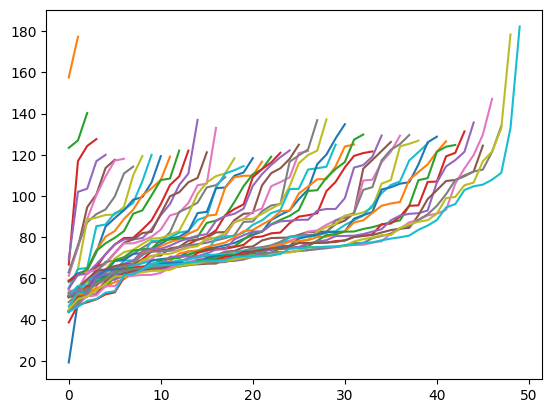

In [ ]:
for elem in mean_scores:
  plt.plot(list(sorted(elem)))

In [ ]:
[r.n_clusters for r in result]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

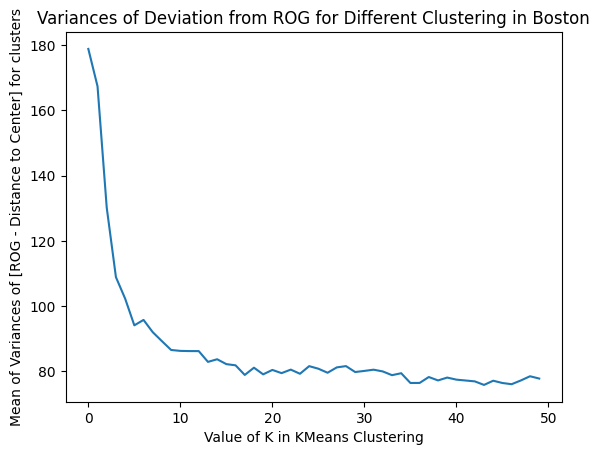

In [ ]:
result.sort(key = lambda x : x.n_clusters)
means = []
scores = [r.score for r in result]

for elem in mean_scores:
  means.append(np.mean(elem))


plt.plot(means)
plt.xlabel('Value of K in KMeans Clustering')
plt.ylabel('Mean of Variances of [ROG - Distance to Center] for clusters')
plt.title('Variances of Deviation from ROG for Different Clustering in Boston')
plt.show()

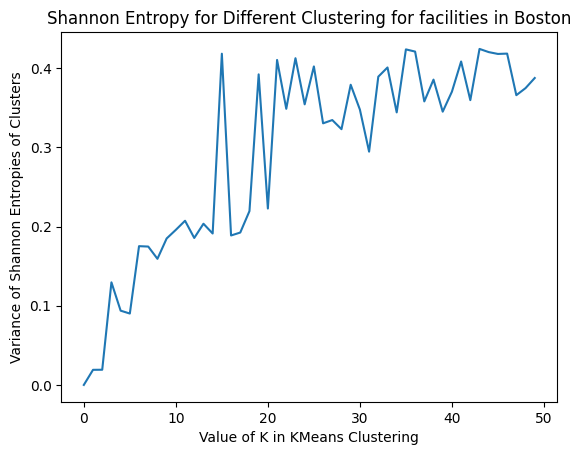

In [ ]:
plt.plot(scores)
plt.xlabel('Value of K in KMeans Clustering')
plt.ylabel('Variance of Shannon Entropies of Clusters')
plt.title('Shannon Entropy for Different Clustering for facilities in Boston')
plt.show()

In [ ]:
OPT_K = 20

In [ ]:
opt_result = result[OPT_K - 1]

In [ ]:
opt_result.n_clusters

20

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import numpy as np
import plotly.express as px

grouped = (opt_result.df).groupby('Label') # Group data by cluster labels

polygons = []
areas = []
densities = []
cardinalities = []
for label, group in grouped:
    points = group[['Longitude', 'Latitude']].values
    hull = ConvexHull(points)

    curr_area = hull.area
    areas.append(curr_area)

    curr_cardinality = group.shape[0]
    cardinalities.append(curr_cardinality)

    densities.append(curr_cardinality/curr_area)

    polygon_coords = [(points[i][0], points[i][1]) for i in hull.vertices]
    polygon = Polygon(polygon_coords)
    polygons.append({'Label': label, 'Polygon': polygon})

gdf = gpd.GeoDataFrame(polygons, geometry='Polygon') # GeoDataFrame from the polygons

fig = px.choropleth_mapbox(
    gdf,
    geojson=gdf.geometry,
    locations=gdf.index,
    color="Label",
    color_continuous_scale=px.colors.qualitative.Set1,
)

fig.update_geos(projection_type="mercator")
fig.update_layout(mapbox={"style": "open-street-map"})
fig.show()

In [ ]:
np.var(densities)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



23656635.502423834

In [ ]:
np.var(areas)

0.005866466277976332

In [ ]:
cardinalities.sort(reverse=True)
sum(cardinalities[:5])/sum(cardinalities[-5:])

8.758936755270394

[(4, 15, 11.727320421974888),
 (4, 0, 25.28095447140923),
 (4, 10, 5.938064268624366),
 (15, 4, 11.727320421974888),
 (15, 0, 16.43735788102233),
 (15, 8, 4.507650757616328),
 (8, 15, 4.507650757616328),
 (8, 0, 20.93985687994271),
 (8, 18, 9.312238414254638),
 (8, 11, 15.71482349193933),
 (8, 2, 19.477725382970668),
 (8, 17, 17.745058054112587),
 (8, 5, 9.76224919980848),
 (5, 8, 9.76224919980848),
 (5, 17, 16.10866599146378),
 (17, 5, 16.10866599146378),
 (17, 8, 17.745058054112587),
 (17, 2, 7.868426418386012),
 (2, 11, 8.247770723947434),
 (2, 17, 7.868426418386012),
 (2, 8, 19.477725382970668),
 (2, 12, 29.09175270858497),
 (11, 12, 31.08708402746643),
 (11, 7, 10.601615813347962),
 (11, 18, 24.840719926552424),
 (11, 8, 15.71482349193933),
 (11, 2, 8.247770723947434),
 (7, 14, 18.64199003398043),
 (7, 18, 14.962957543646583),
 (7, 11, 10.601615813347962),
 (7, 12, 20.97394624633286),
 (7, 19, 15.354651453408316),
 (18, 7, 14.962957543646583),
 (18, 11, 24.840719926552424),
 (18, 

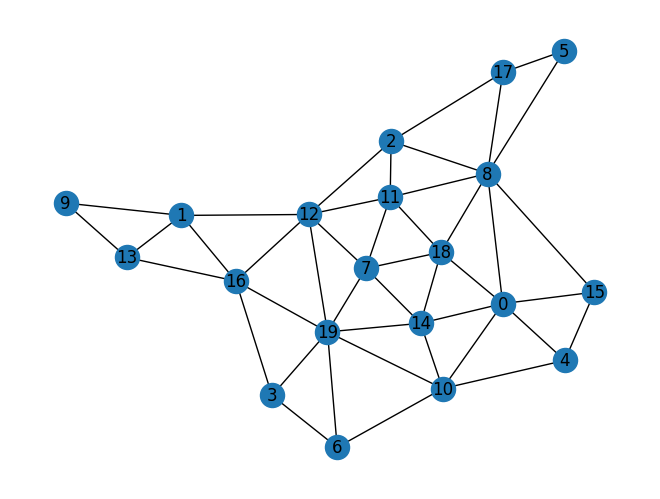

In [ ]:
from pprint import pprint
import networkx as nx

with open("/content/boston_20.txt") as f:
  content = f.read()

lines = content.split("\n")
#list(OPT_RESULT.centers[0][::-1])

edges = []
for line in lines:
  if line:
    nodes = line.split()
    start = int(nodes[0])
    start_center = list((opt_result.centers)[start][::-1]) #to get latitude first

    for i in range(1, len(nodes)):
      end = int(nodes[i])
      end_center = list((opt_result.centers)[end][::-1]) #to get latitude first
      dist = distance(start_center, end_center).km

      curr_tuple = (start, end, dist)
      if start != end:
        edges.append(curr_tuple)

pprint(edges)

G = nx.Graph()
for i in range(OPT_K):
  G.add_node(i)
G.add_weighted_edges_from(edges)


pprint(nx.betweenness_centrality(G))

nx.draw(G, with_labels = True)

In [ ]:
rog_locs

[[-70.632562, 41.76303],
 [-70.631639, 41.76324],
 [-70.632014, 41.763365],
 [-70.631855, 41.763573],
 [-70.632604, 41.763912],
 [-70.632603, 41.764107],
 [-70.632137, 41.764176],
 [-70.631967, 41.764342],
 [-70.630719, 41.764437],
 [-70.633244, 41.765216],
 [-70.631069, 41.765437],
 [-70.633699, 41.765563],
 [-70.633851, 41.765681],
 [-70.63392, 41.765791],
 [-70.633108, 41.765965],
 [-70.633327, 41.765988],
 [-70.631642, 41.766214],
 [-70.633596, 41.766255],
 [-70.633715, 41.766282],
 [-70.634005, 41.7663],
 [-70.633597, 41.7668],
 [-70.633037, 41.766814],
 [-70.627917, 41.766866],
 [-70.634562, 41.766977],
 [-70.633595, 41.767237],
 [-70.634343, 41.767412],
 [-70.627081, 41.767509],
 [-70.634924, 41.767631],
 [-70.62571, 41.767923],
 [-70.633898, 41.768242],
 [-70.617994, 41.768861],
 [-70.625077, 41.769133],
 [-70.618996, 41.769491],
 [-70.623571, 41.769924],
 [-70.618765, 41.76999],
 [-70.618742, 41.770005],
 [-70.618559, 41.770447],
 [-70.619519, 41.770497],
 [-70.624406, 41.7706

In [ ]:
curr_df = opt_result.df
curr_est = opt_result.estimator
curr_centers = opt_result.centers

#get labels for each rog point
rog_labels = curr_est.predict(rog_locs)

rogs = {}
all_rogs = []
for i in range(OPT_K):
  rogs[i] = []

#calculate distances
for i, pt in enumerate(rog_locs):
  curr_label = rog_labels[i]
  curr_center = curr_centers[curr_label]

  curr_rogs = rog_dict[pt[0]][pt[1]]
  rogs[curr_label].extend(curr_rogs)
  all_rogs.extend(curr_rogs)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [ ]:
all_rogs

[35.133332332782224,
 25.80203003108669,
 33.22752932774864,
 37.03893542416889,
 29.230702044939694,
 28.55190875689277,
 38.42665388557446,
 30.96938846850794,
 35.25105225994864,
 34.0096721300122,
 28.55190875689277,
 46.17449305593586,
 28.55190875689277,
 24.817456745906963,
 34.396534349142144,
 34.93134150011946,
 20.600625012939435,
 28.873409134829974,
 24.817456745906963,
 35.133332332782224,
 28.55190875689277,
 28.55190875689277,
 28.55190875689277,
 28.55190875689277,
 33.95166544656566,
 28.55190875689277,
 24.060020621274703,
 28.55190875689277,
 28.55190875689277,
 28.55190875689277,
 28.55190875689277,
 28.55190875689277,
 44.62634868070052,
 28.55190875689277,
 31.334514894364148,
 28.55190875689277,
 27.7197156695851,
 28.55190875689277,
 28.55190875689277,
 34.30741687559023,
 28.55190875689277,
 35.56403577925411,
 1.7467918615833289,
 45.24548295317727,
 42.11998790038992,
 35.35649181234308,
 35.1100718463209,
 51.62082143106946,
 1.6490452202507806,
 25.8261114

(array([0.91526288, 0.99175394, 0.99842353, 0.99949772, 0.99981742,
        0.99993758, 0.99997582, 0.99999278, 0.99999784, 1.        ]),
 array([5.13753106e-03, 2.57924173e+01, 5.15796970e+01, 7.73669767e+01,
        1.03154256e+02, 1.28941536e+02, 1.54728816e+02, 1.80516096e+02,
        2.06303375e+02, 2.32090655e+02, 2.57877935e+02]),
 [<matplotlib.patches.Polygon at 0x7c0761c5f7f0>])

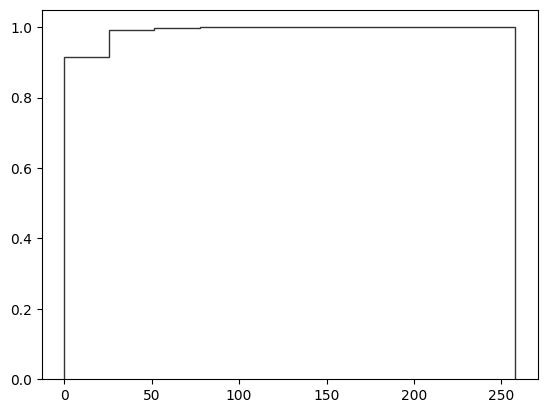

In [ ]:
plt.hist(all_rogs, density=True, cumulative=True, label='CDF', histtype='step', alpha=0.8, color='k')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(array([3.54928048e-02, 2.96623189e-03, 2.58638921e-04, 4.16559223e-05,
        1.23974294e-05, 4.65953044e-06, 1.48321390e-06, 6.57651444e-07,
        1.95896175e-07, 8.39555035e-08]),
 array([5.13753106e-03, 2.57924173e+01, 5.15796970e+01, 7.73669767e+01,
        1.03154256e+02, 1.28941536e+02, 1.54728816e+02, 1.80516096e+02,
        2.06303375e+02, 2.32090655e+02, 2.57877935e+02]),
 [<matplotlib.patches.Polygon at 0x7c0761bc83d0>])

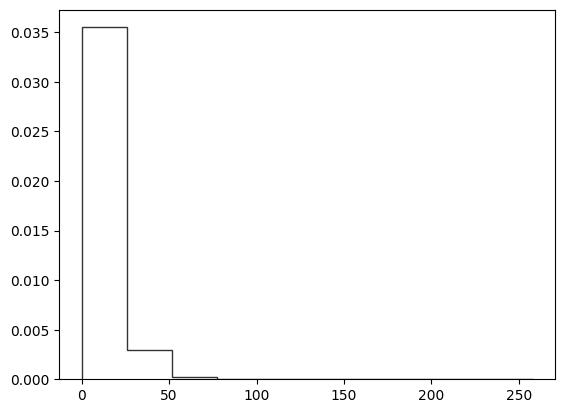

In [ ]:
plt.hist(all_rogs, density=True, cumulative=False, label='PDF', histtype='step', alpha=0.8, color='k')

In [ ]:
opt_centers = opt_result.centers

In [ ]:
opt_centers

array([[-71.02961462,  42.3809665 ],
       [-71.11484996,  42.30716132],
       [-71.13653192,  42.40152718],
       [-71.00628261,  42.20235876],
       [-71.26463973,  42.29801142],
       [-71.06117474,  42.35655373],
       [-70.95652104,  42.4612535 ],
       [-71.13157401,  42.20790906],
       [-71.28019052,  42.4806046 ],
       [-71.10537305,  42.37819026],
       [-71.06364685,  42.43903025],
       [-70.9123601 ,  42.23636418],
       [-71.21470273,  42.35798763],
       [-71.13733573,  42.34966626],
       [-70.99508077,  42.34607583],
       [-71.08703602,  42.34902198],
       [-71.22198948,  42.18466472],
       [-71.04418712,  42.28747876],
       [-71.21523629,  42.45653804],
       [-71.13203866,  42.47401544]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(array([0.01919635, 0.04113505, 0.04113505, 0.04387738, 0.04524855,
        0.0301657 , 0.01782519, 0.01371168, 0.0041135 , 0.0041135 ]),
 array([ 2.28911487,  6.12756294,  9.966011  , 13.80445907, 17.64290714,
        21.48135521, 25.31980328, 29.15825134, 32.99669941, 36.83514748,
        40.67359555]),
 [<matplotlib.patches.Polygon at 0x791aff06f6d0>])

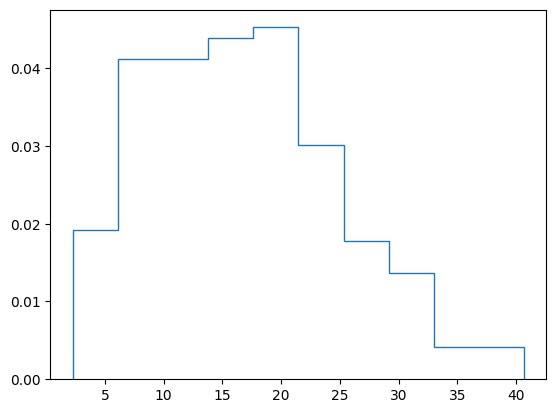

In [ ]:
center_dists = []
for i in range(len(opt_centers)):
  pt_i_formatted = list(opt_centers[i])[::-1]
  for j in range(i):
    pt_j_formatted = list(opt_centers[j])[::-1]
    curr_dist = distance(pt_i_formatted, pt_j_formatted).km
    center_dists.append(curr_dist)

plt.hist(center_dists, density=True, cumulative=False, label='CDF', histtype='step')

In [ ]:
np.mean(center_dists), np.var(center_dists)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(17.236509128966052, 66.35143031692942)

In [ ]:
min(center_dists)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



3.2658657314508996